In [1]:
import re
import numpy as np
import pandas as pd
import dask.array as da
import matplotlib.pyplot as plt
from aicsimageio import AICSImage
from cellpose import models
import napari

In [38]:
# relabel labels to be numbered consecutively
def relabel(mask):
    uniques = np.unique(mask)
    for new, old in enumerate(uniques):
        mask[mask==old] = new
    return mask

## IO

In [2]:
fn = r'Z:\zmbstaff\9309\Raw_Data\240209_datasetwithbothdyes_beforeandafterstimulation\Transduced cell line with dyes.lif'

In [3]:
#fn = r'Z:\zmbstaff\9309\Raw_Data\240216_dataset20x_bothdyes_beforeandafter\Transduced cells 20x test.lif'

In [4]:
lif_img = AICSImage(fn, reconstruct_mosaic=False)

In [5]:
scenes = lif_img.scenes
scenes

('Unstimulated/D3 Position1',
 'Unstimulated/D3 Position1/FLIM/Intensity',
 'Unstimulated/D3 Position1/FLIM/Fast Flim',
 'Unstimulated/D3 Position1/FLIM/Standard Deviation',
 'Unstimulated/D3 Position1/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Unstimulated/D3 Position2',
 'Unstimulated/D3 Position2/FLIM/Intensity',
 'Unstimulated/D3 Position2/FLIM/Fast Flim',
 'Unstimulated/D3 Position2/FLIM/Standard Deviation',
 'Unstimulated/D3 Position2/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Unstimulated/D3 Position3',
 'Unstimulated/D3 Position3/FLIM/Intensity',
 'Unstimulated/D3 Position3/FLIM/Fast Flim',
 'Unstimulated/D3 Position3/FLIM/Standard Deviation',
 'Unstimulated/D3 Position3/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Unstimulated/D3 Position4',
 'Unstimulated/D3 Position4/FLIM/Intensity',
 'Unstimulated/D3 Position4/FLIM/Fast Flim',
 'Unstimulated/D3 Position4/FLIM/Standard Deviation',
 'Unstimulated/D3 Position4/FLIM/Pattern Matching Scatter Plot Channel 1',
 'Un

In [6]:
def parse_scenes(scenes: list[str]) -> pd.DataFrame:
    pattern = r'(?P<cond>.*?)/(?P<well>\w\d+)\ (?P<pos>Position\d+)(?P<subfolder>.*)'
    
    conditions = []
    wells = []
    positions = []
    subfolders = []
    flim_presence = []
    
    # Iterate through data and extract information
    for item in scenes:
        match = re.match(pattern, item)
        conditions.append(match.group('cond'))
        wells.append(match.group('well'))
        positions.append(match.group('pos'))
        subfolders.append(match.group('subfolder'))

    df = pd.DataFrame({
        'condition': conditions,
        'well': wells,
        'position': positions,
        'subfolder': subfolders,
    })

    df = df.query("subfolder==''")

    return df.drop(columns='subfolder')

In [7]:
df = parse_scenes(scenes)
df

,condition,well,position
0,Unstimulated,D3,Position1
5,Unstimulated,D3,Position2
10,Unstimulated,D3,Position3
15,Unstimulated,D3,Position4
20,Unstimulated,D3,Position5
25,Unstimulated,D3,Position6
30,Unstimulated,D3,Position7
35,Unstimulated,D3,Position8
40,IL-2_stimulated,D3,Position1
45,IL-2_stimulated,D3,Position2


In [8]:
scene_data = []
for i, row in df.iterrows():
    lif_img.set_scene(i)
    scene_data.append(lif_img.dask_data)
scene_data = da.stack(scene_data)
scene_data = scene_data[:,0,:,0]

In [9]:
scene_data

dask.array<getitem, shape=(16, 5, 512, 512), dtype=uint16, chunksize=(1, 1, 512, 512), chunktype=numpy.ndarray>

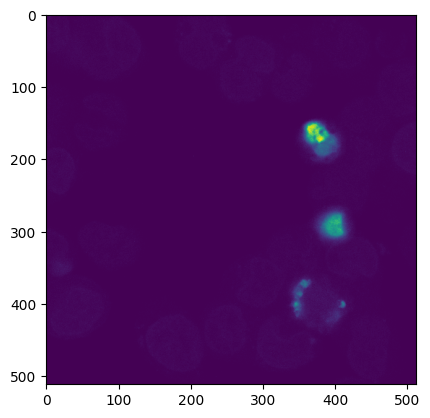

In [10]:
plt.imshow(scene_data[0,2].compute())

In [11]:
data = da.stack([scene_data[:,2], scene_data[:,0]+scene_data[:,1]], axis=1).astype(float)
#data = [img for img in data.compute()]
data[:,0] = (data[:,0] - 0) / 20
data[:,1] = (data[:,1] - 0) / 512

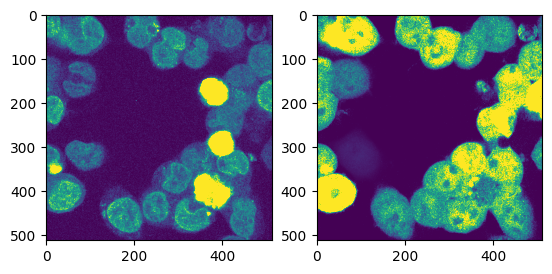

In [12]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(data[0,0], vmin=0, vmax=1)
axs[1].imshow(data[0,1], vmin=0, vmax=1)

## cellpose

In [13]:
%%time
data_cp = [im for im in data.compute()]

CPU times: total: 13.3 s
Wall time: 12.7 s


### nuclei

In [18]:
%%time
model_nucleus = models.Cellpose(gpu=True, model_type='nuclei')
masks_nucleus, *_ = model_nucleus.eval(
    data_cp,
    diameter=60,
    channels=[1,0],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=False,
)
masks_nucleus = np.stack(masks_nucleus)

CPU times: total: 8.28 s
Wall time: 8.31 s


### cells

In [19]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[2,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=False,
)
masks_cell = np.stack(masks_cell)

CPU times: total: 8.91 s
Wall time: 9.04 s


In [21]:
viewer = napari.Viewer()
viewer.add_image(scene_data, channel_axis = 1)
viewer.add_labels(masks_nucleus)
viewer.add_labels(masks_cell)

viewer.layers[2].contrast_limits = [0,20]

In [22]:
viewer.layers[2].contrast_limits = [0,32]

# Filtering

### Remove nuclei from cell-masks

In [32]:
masks_cyto = []
for i, (mask_cell, mask_nucleus) in enumerate(zip(masks_cell, masks_nucleus)):
    mask_cyto = mask_cell.copy()
    mask_cyto[mask_nucleus!=0] = 0
    masks_cyto.append(mask_cyto)

### Filter for nucleus / cytoplasm size

In [33]:
sizes_nuc_all = []
sizes_cyt_all = []
for i, (mask_cell, mask_cyto) in enumerate(zip(masks_cell, masks_cyto)):
    sizes_nuc = []
    sizes_cyt = []
    for n in range(1, mask_cell.max()+1):
        sizes_nuc.append(np.count_nonzero(mask_cell==n) - np.count_nonzero(mask_cyto==n))
        sizes_cyt.append(np.count_nonzero(mask_cyto==n))
    sizes_nuc_all.append(sizes_nuc)
    sizes_cyt_all.append(sizes_cyt)

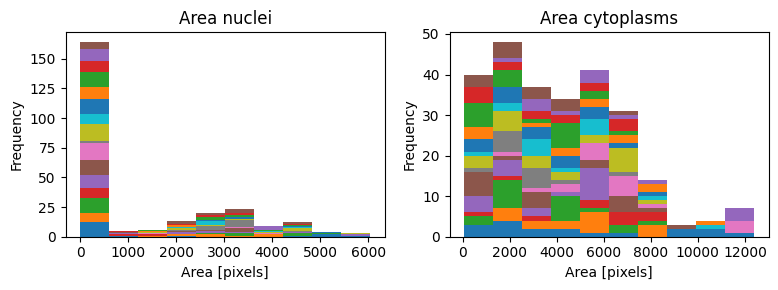

In [34]:
fig, axs = plt.subplots(1,2, figsize=(8,3))

axs[0].set_title('Area nuclei')
axs[0].hist(sizes_nuc_all, histtype='bar', stacked=True)
axs[0].set_xlabel('Area [pixels]')
axs[0].set_ylabel('Frequency')

axs[1].set_title('Area cytoplasms')
axs[1].hist(sizes_cyt_all, histtype='bar', stacked=True)#, label=[f"file {i}" for i in range(len(fns))])
#axs[1].legend(prop={'size': 10})
axs[1].set_xlabel('Area [pixels]')
axs[1].set_ylabel('Frequency')

plt.tight_layout()

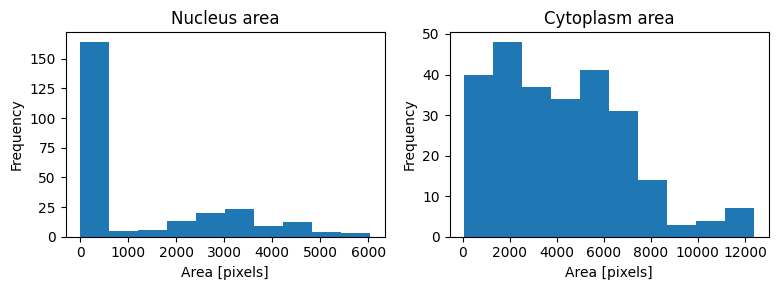

In [35]:
fig, axs = plt.subplots(1,2, figsize=(8,3))

axs[0].set_title('Nucleus area')
axs[0].hist(np.concatenate(sizes_nuc_all), histtype='bar')
axs[0].set_xlabel('Area [pixels]')
axs[0].set_ylabel('Frequency')

axs[1].set_title('Cytoplasm area')
axs[1].hist(np.concatenate(sizes_cyt_all), histtype='bar')
axs[1].set_xlabel('Area [pixels]')
axs[1].set_ylabel('Frequency')

plt.tight_layout()

In [36]:
# define cutoffs for nucleus and cytoplasm areas
min_area_nuc = 1000
min_area_cyto = 1000

In [39]:
masks_cyto_filt = []
for i, (mask_cyto, sizes_nuc, sizes_cyt) in enumerate(zip(masks_cyto, sizes_nuc_all, sizes_cyt_all)):
    mask_cyto_filt = mask_cyto.copy()
    for n, (size_nuc, size_cyt) in enumerate(zip(sizes_nuc, sizes_cyt)):
        if size_nuc<min_area_nuc or size_cyt<min_area_cyto:
            mask_cyto_filt[mask_cyto==n+1] = 0
    masks_cyto_filt.append(mask_cyto_filt)
masks_cyto_filt = [relabel(mask_cyto_filt) for mask_cyto_filt in masks_cyto_filt]

### Summary

In [44]:
fig, axs = plt.subplots(len(mask_cell),6, figsize=(18,3*len(mask_cell)))
for i, (img, mask_cell, mask_nucleus, mask_cyto, mask_cyto_filt) in enumerate(zip(data, masks_cell, masks_nucleus, masks_cyto, masks_cyto_filt)):
    axs[i,0].set_title("Donor+Acceptor")
    axs[i,0].imshow(img[2])
    axs[i,1].set_title("Cell mask (cellplose)")
    axs[i,1].imshow(mask_cell)
    axs[i,2].set_title("Nuclear signal")
    axs[i,2].imshow(img[3])
    axs[i,3].set_title("Nuclear mask")
    axs[i,3].imshow(mask_nucleus)
    axs[i,4].set_title("Cytoplasm mask")
    axs[i,4].imshow(mask_cyto)
    axs[i,5].set_title("Cytoplasm mask, filtered")
    axs[i,5].imshow(mask_cyto_filt)
plt.tight_layout()

IndexError: Index 2 is out of bounds for axis 0 with size 2

Error in callback <function _draw_all_if_interactive at 0x0000024693FD7060> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 1800x153600 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1800x153600 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1800x153600 with 3072 Axes>

In [19]:
viewer = napari.Viewer()
viewer.add_image(np.stack([img[[0,1,3,4]] for img in imgs]), channel_axis=1, name=['donor','acceptor','nucleus','actin'])
viewer.add_labels(np.stack(masks_nucleus), name='masks_nucleus', visible=False)
viewer.add_labels(np.stack(masks_cyto), name='masks_cyto', visible=False)
viewer.add_labels(np.stack(masks_cyto_filt), name='masks_cyto_filt')

<Labels layer 'masks_cyto_filt' at 0x1ec303bba90>

# Tracking

In [84]:
from skimage.measure import regionprops
from stardist.matching import matching

def match_labels(ys, iou_threshold=0):
    """
    Matches object ids in a list of label images based on a matching criterion.
    For i=0..len(ys)-1 consecutively matches ys[i+1] with ys[i],
    matching objects retain their id, non matched objects will be assigned a new id
    Example
    -------
    import numpy as np
    from stardist.data import test_image_nuclei_2d
    from stardist.matching import match_labels
    _y = test_image_nuclei_2d(return_mask=True)[1]
    labels = np.stack([_y, 2*np.roll(_y,10)], axis=0)
    labels_new = match_labels(labels)
    Parameters
    ----------
    ys : np.ndarray, tuple of np.ndarray
          list/array of integer labels (2D or 3D)
    """

    ys = np.asarray(ys)
    if not ys.ndim in (3, 4):
        raise ValueError('label image y should be 3 or 4 dimensional!')

    def _match_single(x, y):
        res = matching(x, y, report_matches=True, thresh=0)

        pairs = tuple(p for p, s in zip(res.matched_pairs,
                      res.matched_scores) if s >= iou_threshold)
        map_dict = dict((i2, i1) for i1, i2 in pairs)

        y2 = np.zeros_like(y)
        y_labels = set(np.unique(y)) - {0}

        # labels that can be used for non-matched objects
        label_reservoir = list(
            set(np.arange(1, len(y_labels)+1)) - set(map_dict.values()))
        for r in regionprops(y):
            m = (y[r.slice] == r.label)
            if r.label in map_dict:
                y2[r.slice][m] = map_dict[r.label]
            else:
                y2[r.slice][m] = label_reservoir.pop(0)

        return y2

    ys_new = ys.copy()

    for i in range(len(ys)-1):
        ys_new[i+1] = _match_single(ys_new[i], ys[i+1])

    return ys_new

In [101]:
labels = masks_cell[[0,8]]

In [102]:
matched_labels = match_labels(labels, iou_threshold=0.5)

In [103]:
matched_labels_filtered = matched_labels
for i in range(matched_labels_filtered.max()):
    if not (i in matched_labels_filtered[0] and i in matched_labels_filtered[1]):
        matched_labels_filtered[matched_labels_filtered==i] = 0

In [104]:
viewer = napari.Viewer()
#viewer.add_image(data_cp, channel_axis=0, name=['donor','acceptor','nucleus','actin'])
viewer.add_labels(labels, name='unmatched')
viewer.add_labels(matched_labels, name='matched')
viewer.add_labels(matched_labels_filtered, name='matched-filtered')

<Labels layer 'matched-filtered' at 0x2489ea66850>

## cellpose

In [68]:
data_cp = np.stack([data[0].compute(),data[8].compute()],axis=1)

In [71]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell_track, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[2,1],
    z_axis=1,
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    stitch_threshold=0.5,
    normalize=False,
)
masks_cell_track = np.stack(masks_cell_track)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]

CPU times: total: 2.95 s
Wall time: 2.89 s


In [77]:
viewer = napari.Viewer()
viewer.add_image(data_cp, channel_axis=0, name=['donor','acceptor','nucleus','actin'])
viewer.add_labels(masks_cell_track, name='masks_cells')
#viewer.add_labels(np.stack(masks_cyto), name='masks_cyto', visible=False)
#viewer.add_labels(np.stack(masks_cyto_filt), name='masks_cyto_filt')

<Labels layer 'masks_cells' at 0x2480657b690>

In [73]:
napari.view_labels(masks_cell_track)

Viewer(camera=Camera(center=(0.0, 255.5, 255.5), zoom=1.5265606574292452, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(0.0, 1.0, 0.0), scaled=True, size=10, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 2.0, 1.0), (0.0, 512.0, 1.0), (0.0, 512.0, 1.0)), current_step=(0, 255, 255), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Labels layer 'masks_cell_track' at 0x24894716090>], help='use <1> for activate the label eraser, use <2> for activate the paint brush, use <3> for activate the fill bucket, use <4> for pick mode', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x000002471062FD80>], _persisted_mouse_event={}, _mouse_d

In [62]:
?model_nucleus.eval

Signature:
model_nucleus.eval(
    x,
    batch_size=8,
    channels=None,
    channel_axis=None,
    z_axis=None,
    invert=False,
    normalize=True,
    diameter=30.0,
    do_3D=False,
    anisotropy=None,
    net_avg=False,
    augment=False,
    tile=True,
    tile_overlap=0.1,
    resample=True,
    interp=True,
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    min_size=15,
    stitch_threshold=0.0,
    rescale=None,
    progress=None,
    model_loaded=False,
)
Docstring:
run cellpose and get masks

Parameters
----------
x: list or array of images
    can be list of 2D/3D images, or array of 2D/3D images, or 4D image array

batch_size: int (optional, default 8)
    number of 224x224 patches to run simultaneously on the GPU
    (can make smaller or bigger depending on GPU memory usage)

channels: list (optional, default None)
    list of channels, either of length 2 or of length number of images by 2.
    First element of list is the channel to segment (0=grayscale, 1=red, 

### nuclei

In [18]:
%%time
model_nucleus = models.Cellpose(gpu=True, model_type='nuclei')
masks_nucleus, *_ = model_nucleus.eval(
    data_cp,
    diameter=60,
    channels=[1,0],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=False,
)
masks_nucleus = np.stack(masks_nucleus)

CPU times: total: 8.28 s
Wall time: 8.31 s


### cells

In [19]:
%%time
model_cell = models.Cellpose(gpu=True, model_type='cyto2')
masks_cell, *_ = model_cell.eval(
    data_cp,
    diameter=80,
    channels=[2,1],
    flow_threshold=0.4,
    cellprob_threshold=0.0,
    do_3D=False,
    normalize=False,
)
masks_cell = np.stack(masks_cell)

CPU times: total: 8.91 s
Wall time: 9.04 s


In [47]:
masks_cell.shape

(16, 512, 512)

In [56]:
labels = masks_cell[[0,8]]

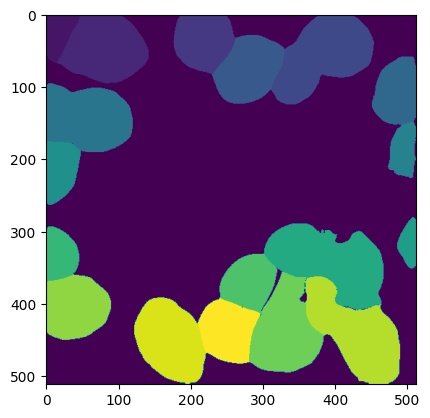

In [59]:
plt.imshow(labels[0])

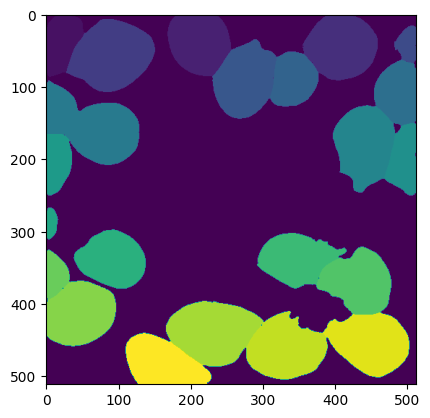

In [60]:
plt.imshow(labels[1])

In [61]:
match_labels(labels)

NameError: name 'matching' is not defined